# Lecture 13: False Discovery Rate, Complex Encoding Models & Decoding

## Goals

- **Neuroscience / Neuroimaging concepts**
    - Significance tests for Prediction Accuracy
    - Modeling brain responses as a function of complex stimulus features
    - Comparing models as hypothesis testing
- **Datascience / Coding concepts**
    - Family Wise Error Rate
    - False Discovery Rate
    - Benjamini-Hochberg Procedure for FDR Correction

# Setup

Simply run the cells below that contain all the Python modules we'll neeed, plus setup matplotlib for plotting in this jupyter notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import cortex
import os
import h5py
import json
import urllib
from scipy.stats import zscore
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LinearRegression

np.random.seed(42)

# Set plotting defaults
%matplotlib inline

## Helper Functions

In [2]:
def z_score(x):
    x = x - x.mean(axis=0)
    x = x / (x.std(axis=0) + 1e-18)
    return x

In [3]:
def correlate(x, y):
    x_z = z_score(x)
    y_z = z_score(y)
    return np.mean(x_z*y_z, axis=0)

# Review



## Event Related Design Review

Up until this point in the course we've been using fMRI data that came from a block designed visual localizer experiment. Several lectures ago we learned there are other ways to design an experiment, one of which being an event-related design. Today we'll use some fMRI data from an event-related design to go deeper into encoding models, but first we'll quickly review event-related designs.

Block designs have relatively high levels of SNR for an fMRI design. This high level of SNR comes at a cost however; block designs are not temporally efficient, they take a long time to show just a few different types of stimuli. Since time in the MRI machine is expensive (several hundred dollars an hour), this is not an efficient way to conduct fMRI research. 

A better way would be to show many different stimuli (or trial) types in a [pseudo]-random order. This would allow for many different stimulus types and shorter scan times. So called fast event-related designs present a stimulus every 4 seconds or so. Below is an example image of what a fast event-related design exepriment looks like.

<img src='figures/event_relatedA.PNG' style="width: 400px">

### Event-Related Designs and the HRF

A potential problem with event-related designs is that the BOLD signal responds slowly (peaks at about 5 seconds), and so if we show many different types of stimuli in a row, the BOLD signal response from one stimulus will "bleed over" into the TRs of the neighboring stimuli. In other words, if we want to make an accurate mathematical model of how the brain responds to a given stimulus, we have to incorporate this delay into our model. 
See the image below for an illustration.

<img src='figures/event_related.PNG' style="width: 400px">

This problem has a solution however, and it involves characterizing the Hemodynamic Response Function (HRF) and then using that HRF to model the BOLD data.

To do this, we will borrow a concept from signal processing theory called the impulse response function. An impulse response function describes a system's response (this can be the signal that we measure using fMRI) to an external change (e.g. the stimulus or event onset). As we know, fMRI measures BOLD signal and not neuronal activity directly. Therefore, to model the hemodynamic response (BOLD signal) to an event we would like to have a function that describes what the BOLD signal looks like when it responds to a given event. This function is called the *hemodynamic response function* or HRF, and is an example of an impulse response function. 

A great deal of early fMRI research went into accurately describing how the BOLD signal rises, falls, and resets to baseline after an event (i.e. characaterizing the HRF). We will rely on the conclusions of this research without going into much detail about it. For an overview of hemodynamic responses in fMRI, check out [this blog post](http://mindhive.mit.edu/node/72). The practical upshot of this work is that BOLD responses have a fairly characteristic shape, which is well described by a mathematical function called the *gamma function*. 


## Load Data from an Event-Related fMRI Experiment

Now we'll load a file containing the fMRI data from an event-related experiment in which naturalistic images of many different types of semantic categories (what is the image of) where shown to subjects while BOLD data was collected. This data has been preprocessed in a way that we haven't yet discussed. They are stored as **response amplitudes** to each of the images, in each voxel. A response amplitude is simply the estimated response to the image, after the HRF has been removed. The HRF is removed through a process called **deconvolution**, and this results in a single number for each image, the response amplitude. How deconvolution works is beyond the scope of this course, but you should understand what it results in (i.e response amplitudes).

This data is stored in a new type of file called an **HD5** file. These files are used to store very large data sets, and are a useful tool in the data scientist's toolbox. You don't need to know how to load or manipulate HD5 data however.

In [4]:
data_file = h5py.File("/data/cogneuro/fMRI/images/s04_color_natims_data.hdf")
data_train = data_file['est'][:]
data_test = data_file['val'][:]
data_train.shape, data_test.shape

((1260, 65242), (126, 65242))

This data is a 2-D matrix where the columns are cortical voxels, and each row represents response amplitudes for the images in the experiment. The data has already been split into a training set and a  test set so that we can do cross-validation and predict the test set. There are `1260` images in the training set and `126` images in the test set. Each training image was shown 2 times to the subject, and each test image was shown `10`. 

Some of the voxels in this data set contain missing data (nan) because they exist near the edge of the brain and the subject moved during some of the scans. Let's create a binary mask that indicates the voxels that contain at least one `nan` in either the training or test data. 

In [5]:
nanmap = np.isnan(data_train).any(axis=0) | np.isnan(data_test).any(axis=0)

We want to z-score this data, but can't when there are `nan` values in the data. We also can't just set the `nan` values to a single value, because the zscore operation divides by the standard deviation, and if all the values of a vector are the same the standard deviation is `0`, and it is an undefined operation to divide by zero. So we'll set the voxels with `nan` values to random data, zscore the data, and set those same voxels back to 0.

In [6]:
rand_train_column = np.random.rand(data_train.shape[0],1)
rand_test_column = np.random.rand(data_test.shape[0],1)
data_train[:, nanmap] = rand_train_column
data_test[:, nanmap] = rand_test_column
data_train = zscore(data_train, axis=0)
data_test = zscore(data_test, axis=0)
data_train[:, nanmap] = 0.
data_test[:, nanmap] = 0.

Calculate the size of the test and training data sets.

In [7]:
n_train = data_train.shape[0]
n_test = data_test.shape[0]
num_cortical_voxels = data_train.shape[1]

We have several encoding models we will fit to this data. The first is a simple 3 category model. Each category represents one broad semantic category. Let's load a file that contains the names of the categories (aka. features)

In [8]:
features_sem3_filename = "/data/cogneuro/fMRI/images/color_natims_features_3cat.json"
features_sem3 = json.load(open(features_sem3_filename, 'r'))
features_sem3

['humans', 'objects', 'places']

So we have humans, objects and places. Each image can contain any combination of those features, including none of them or all of them. Let's load the design matrix containing the features for all of the training and test data sets.

In [9]:
designmat_sem3_file = h5py.File("/data/cogneuro/fMRI/images/color_natims_features_3cat.hdf")
designmat_sem3_train = zscore(designmat_sem3_file['est'][:], axis=0)
designmat_sem3_test = zscore(designmat_sem3_file['val'][:], axis=0)
designmat_sem3_train.shape, designmat_sem3_test.shape

((1260, 3), (126, 3))

## Model Prediction

Last week we learned that encoding models define an entire feature space that describes all the properties of the stimuli or task that the scientist thinks a given brain region might respond to. These encoding models act as hypotheses for what the brain region represents. To test those hypotheses we need to have some way to quantify how well an entire encoding model explains the changes in the BOLD signal. We saw that by using the linear model to predict the BOLD data, and then correlating the real BOLD data with the predicted data, we can get a metric of how well an entire encoding model describes the fluctations in each voxel. We called that correlation prediction accuracy. 

Let's review how we calculated prediction accuracy on this new event related experiment, using the 3-semantic category model as our encoding model. 

**NOTE** Since this data has been deconvolved, we are not predicting BOLD signals, rather response amplitudes.</div>

### Calculate Prediction Accuracy

First we'll fit a linear model on the training data, using the 3-semantic encoding model's designmatrix as the independent variables, and the training response amplitudes as the dependent variables. We'll fit this model for all voxels in one function call.

In [10]:
model_semantic3 = LinearRegression()
model_semantic3.fit(designmat_sem3_train, data_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
model_semantic3.coef_.shape

(65242, 3)

Predict the training data and correlate those predictions with the real response amplitudes.

In [12]:
pred_sem3_train = model_semantic3.predict(designmat_sem3_train)

In [13]:
pred_sem3_train.shape

(1260, 65242)

In [14]:
data_train.shape

(1260, 65242)

In [15]:
pred_acc_sem3_train = correlate(data_train, pred_sem3_train)

In [16]:
pred_acc_sem3_train.shape

(65242,)

In [17]:
idxs = np.argsort(pred_sem3_train[:,vox_idx_best_3sem])
fig = plt.figure(figsize=(20,5))
plt.plot(pred_sem3_train[idxs,vox_idx_best_3sem], label='Predicted Response Amplitudes')
plt.plot(data_train[idxs,vox_idx_best_3sem], label='Actual Response Amplitudes')
plt.legend()

NameError: name 'vox_idx_best_3sem' is not defined

Now let's plot the prediction accuracy onto a flatmap. This data comes from a new subject, `subject=s04`, and uses a different transformation, `xfmname='color_natims'` (color natural images). We'll also show you a new colormap, called `cmap='hot'` that is very useful for plotting prediction accuracies.

In [ ]:
volume_pred_acc_sem3_train = cortex.Volume(pred_acc_sem3_train, subject='s04', xfmname='color_natims', cmap='hot')
_ = cortex.quickflat.make_figure(volume_pred_acc_sem3_train)

### Overfitting

We just predicted the same data on which we fit the encoding model. There's a problem with calculating prediction accuracy on the same data that you use to fit the model, and it's called **overfitting**. Because the data is noisy, each independent variable that we add generally fits some of the signal and some of the noise in that signal. We're interested in how well our model fits just the signal, but when we predict the training set we're predicting both signal and noise. To overcome this data scientists use a test set to calculate prediction accuracy on. 

First we'll find a voxel that is well predicted by this 3 semantic category encoding model to illustrate how overfitting differentially affects the training and test data. The voxel with the highest prediction accuracy will do. 

In [ ]:
vox_idx_best_3sem = np.argmax(pred_acc_sem3_train)
vox_idx_best_3sem

In [ ]:
data_best_3sem_train = data_train[:,vox_idx_best_3sem]
data_best_3sem_test = data_test[:,vox_idx_best_3sem]
data_best_3sem_train.shape, data_best_3sem_test.shape

Last week we saw that adding independent variables that are just noise decreases the sum of squared errors (SSE) on the training data. This is known as **in-sample** SSE, and decreases due to overfitting to the noise in the training data. Predicting on a separate test set, and computing the **out-of-sample** SSE, works to control some of that overfitting. 

Let's add an increasing number of noise independent variables to the 3-category semantic encoding model and calculate both the in and out of sample error rates to see how they are differentially affected. We'll switch things up just a bit by calculating the **mean squared error (MSE)**, instead of SSE, because we want to compare in and out of sample error, and the test and training are different lengths of data. If we used SSE then the in-sample SSE would be MUCH higher than the out-of-sample SSE. 

**Mean Squared Error (MSE)** is just SSE divided by the number of data points:

$$ \frac{\sum{(y-\hat{y})^2}}{n} $$

In [ ]:
in_sample_MSE = np.zeros(n_test)
out_sample_MSE = np.zeros(n_test)

model_overfit = LinearRegression()
model_overfit.fit(designmat_sem3_train,data_best_3sem_train)

pred_train_best_vox = model_overfit.predict(designmat_sem3_train)
in_sample_MSE[0] = np.sum((data_best_3sem_train-pred_train_best_vox)**2)/n_train

pred_test_best_vox = model_overfit.predict(designmat_sem3_test)
out_sample_MSE[0] = np.sum((data_best_3sem_test-pred_test_best_vox)**2)/n_test

random_indep = np.random.randn(n_train+n_test, n_test)
for i in np.arange(n_test-1):
    designmat_sem3_train_overfit = np.concatenate((designmat_sem3_train, random_indep[:n_train,:i]), axis=1)
    model_overfit.fit(designmat_sem3_train_overfit,data_best_3sem_train)

    pred_train_overfit = model_overfit.predict(designmat_sem3_train_overfit)
    in_sample_MSE[i+1] = np.sum((data_best_3sem_train-pred_train_overfit)**2)/n_train

    designmat_sem3_test_overfit = np.concatenate((designmat_sem3_test, random_indep[n_train:,:i]), axis=1)
    pred_test_overfit = model_overfit.predict(designmat_sem3_test_overfit)
    out_sample_MSE[i+1] = np.sum((data_best_3sem_test-pred_test_overfit)**2)/n_test

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(in_sample_MSE, label='In-sample MSE')
plt.plot(out_sample_MSE, label='Out-of-sample MSE')
plt.legend()
plt.xlabel('# of independent variables')
_ = plt.ylabel("MSE")

### Calculating Significance of Prediction Accuracy

In order to determine where an encoding model is significantly predicting brain activity we need to do some kind of hypothesis testing on each voxel's prediction accuracy. To do this we'll use the same permutation test method that we applied to find significant contrasts in previous lectures. 

Since the y data in this experiment is response amplitudes, and not raw BOLD data, we don't need to account for the HRF, since it's already been deconvolved from the BOLD signal. Thus, to do the permutation test, we can simply shuffle the rows of the design matrix on each permutation, making the permutation test simpler. After fitting a linear regression to each permutation, we'll calculate prediction accuracy instead of a contrast, and store that prediction accuracy in the null distribution. Let's have a look.

In [ ]:
def standard_shuffle(x):
    permute_indices = np.arange(x.shape[0])
    np.random.shuffle(permute_indices)
    return x[permute_indices]

In [ ]:
# Step 1: define the number of resamples to do
NUM_RESAMPLES = 100

# Step 2: create the null distribution vector
null_dist_pred_acc = np.zeros((NUM_RESAMPLES, num_cortical_voxels))

# Step 3: loop and resample to create the null distribution
for cur_iter in range(NUM_RESAMPLES):
    
    # Step 3a: resample the design matrix without replacement by shuffling the the rows 
    cur_designmat_shuffle = standard_shuffle(designmat_sem3_test)
    
    # Step 3b: calculate the contrast value using the current shuffled design matrix
    cur_pred = model_semantic3.predict(cur_designmat_shuffle)
    cur_pred_acc = correlate(data_test, cur_pred)
    
    # Step 3c: store the prediction accuracy map in the null distribution vector
    null_dist_pred_acc[cur_iter, :] = cur_pred_acc

# Step 4: Calculate the p-value to determine signifiance
pred_sem3_test = model_semantic3.predict(designmat_sem3_test)
pred_acc_sem3_test = correlate(data_test, pred_sem3_test)
num_greater_null_pred_acc = (null_dist_pred_acc > pred_acc_sem3_test).sum(axis=0)
p_value_pred_acc = (num_greater_null_pred_acc + 1) / (NUM_RESAMPLES+1)

In [24]:
pred_sem3_test = model_semantic3.predict(designmat_sem3_test)
pred_acc_sem3_test = correlate(data_test, pred_sem3_test)

In [ ]:
null_dist_pred_acc.shape

In [ ]:
pred_acc_sem3_test.shape

In [ ]:
num_greater_null_pred_acc = (null_dist_pred_acc > pred_acc_sem3_test).sum(axis=0)


In [ ]:
nanmap.shape

In [ ]:
p_value_pred_acc_nan = np.zeros((num_cortical_voxels))
p_value_pred_acc_nan[:] = p_value_pred_acc
p_value_pred_acc_nan[nanmap] = np.nan

### Flatmap of Significant Voxels

In [ ]:
volume_pvalue_pred_acc = cortex.Volume(1-p_value_pred_acc_nan, subject='s04', xfmname='color_natims', vmin=.95, vmax=1, cmap='hot')
_ = cortex.quickshow(volume_pvalue_pred_acc)

In [ ]:
_ = cortex.webgl.show(volume_pvalue_pred_acc)

# Multiple Comparison Correction

When multiple hypothesis tests are conducted the risk that you're conclusions are false increases. Since we use an alpha threshold that is not `0` (usually `.05`), there's some chance that we've said there's a real significant finding, when in fact it's not real. The more tests you do, the higher the chance that you'll incorrectly declare a a significant finding. Multiple comparison corrections are a set of techniques you can use to correct this problem. 

## Bonferroni Correction

If multiple hypotheses are tested, the chance of a rare event increases, and therefore, the likelihood of incorrectly rejecting a null hypothesis (i.e., making a Type I error) increases. The Bonferroni correction compensates for that increase by testing each individual hypothesis at a significance level of `alpha/m`, where alpha is the desired overall alpha level and m is the number of hypotheses. For example, if a trial is testing `m=20` hypotheses with a desired `alpha = 0.05`, then the Bonferroni correction would test each individual hypothesis at `alpha = 0.05 / 20 = 0.0025`.

from: https://en.wikipedia.org/wiki/Bonferroni_correction

Let's use the Bonferroni correction to adjust the alpha level for all cortical voxels.

In [ ]:
alpha = 0.05
alpha_adjusted = alpha / num_cortical_voxels
alpha_adjusted

Now we can use this adjusted p-value to determine significance. Let's recreate a map that uses this value.

In [ ]:
pred_acc_sig_Bon = p_value_pred_acc < alpha_adjusted

In [ ]:
volume_pvalue_pred_acc = cortex.Volume(pred_acc_sig_Bon, subject='s04', xfmname='color_natims', vmin=.95, vmax=1, cmap='hot')
_ = cortex.quickshow(volume_pvalue_pred_acc)

### Load p-values from Large Null Distribution

Doing permutation tests takes a long time at a lot of memory, both of which we're limited by in this class. We want to have p-values that would survive a Bonferroni correction, if they are truly small enough, so we've created p-value maps for the encoding models that we'll use in class today by doing permutation tests with a large number of permuations (1 x 10^7 permutations).

In [ ]:
# 19 cat 1e8 https://berkeley.box.com/shared/static/imb6i0hvifh32m9zto7cbxlspoeeritm.npz
# 3 cat 1e7 https://berkeley.box.com/shared/static/60bt29r9v1nkgb55z210yrpg2tf51ht0.npz
# 3 cat 1e8 https://berkeley.box.com/shared/static/awbhvtg00c8km37z047qnqj3ibbqeblq.npz
# 19 cat 1e7 https://berkeley.box.com/shared/static/z5wwm19t478yxn2uey0sr487gjsmyqxp.npz
urllib.request.urlretrieve("https://berkeley.box.com/shared/static/60bt29r9v1nkgb55z210yrpg2tf51ht0.npz",
                           "/home/jovyan/p_3cat_1e7.npz")


In [ ]:
p_3cat_1e7_file = np.load("/home/jovyan/p_3cat_1e7.npz")
p_value_pred_acc_large = (p_3cat_1e7_file['counts'] + 1) / (p_3cat_1e7_file['cur_iter'] + 1)

Let's apply the Bonferroni adjusted alpha rate to the p-values we just loaded and see if anything survives.

In [ ]:
pred_acc_sig_Bon_large = p_value_pred_acc_large < alpha_adjusted

In [ ]:
volume_pvalue_pred_acc = cortex.Volume(1-p_value_pred_acc_nan, subject='s04', xfmname='color_natims', vmin=.95, vmax=1, cmap='hot')
_ = cortex.quickshow(volume_pvalue_pred_acc)

In [ ]:
volume_pvalue_pred_acc_large = cortex.Volume(pred_acc_sig_Bon_large, subject='s04', xfmname='color_natims', vmin=0, vmax=1, cmap='Reds')
_ = cortex.quickshow(volume_pvalue_pred_acc_large)

That's more like it! There are some voxels where the encoding model predicts significantly. But it could be better! Let's explore another way to control for multiple comparisons called **False Discovery Rate Correction**.

## False Discovery Rate (FDR) Correction

The Bonferroni correction we just covered is a type of multiple comparison correction called **Family Wise Error Correction (FWER)**. 
* FWER controls the alpha value so that the probability is $\alpha$ that there is a SINGLE false positive.

There is another type of multiple comparison correction called **False Dicovery Rate (FDR) correction**.
* FDR allows for %q% proportion of the significant hypothesis tests to be false postives, meaning they're not actually true.

This is a more relaxed correction, since up to 5% of the significant values can actually be false, which is comparable to accepting a 5% chance that a single hypothesis test is false (when alpha=`.05`)

The **Benjamini-Hochberg procedure** is the most commonly used FDR correcion. Let's get a better intuition of what a False Discovery Rate really is, then we'll see how the Benjamini-Hochberg procedure limits FDR at a given value.

[Here's a great video explanation of both FDR and Benjamini Hochberg](https://www.youtube.com/watch?v=K8LQSvtjcEo)

### False Discovery Rate (FDR)
To illustrate what a false discovery rate is, and how to correct for it, we'll use some simulated data. Let's imagine you've done an experiment where you record fMRI data while subjects' listen to many different types of music, one of which is heavy metal. We also will record fMRI data while the subject is resting with no music being played. Our hypotheses is:
* Heavy metal will activate two brain regions (vs. rest) thought to be involved in emotional arousal that we'll creatively call Region A and Region B.

#### Null Hypothesis True: Metal vs Rest in Region A

Even though our hypothesis is that metal will activate Region A more than rest, we're actually going to assume that this hypothesis is not true, which means that the null hypothesis that the activity is the same during metal and rest is true in all the voxels of Region A . We'll simulate this by creating a fake contrast value for each of the `1000` voxels in this example. We'll draw the contrast values from the standard normal distribution, which is a bell curve (or Gaussian) with a mean of 0 and standard deviation of 1. 

In [ ]:
NUM_MUSIC_VOXELS = 1000

music_contrast_regionA = np.random.randn(1000)
_ = plt.hist(music_contrast_regionA, bins=10)

We want to calculate p-values for these fake contrasts values. Since we're simulating data we know that the data we've created comes from a standard normal distribution, since we coded it that way! That means we can cheat a little bit and use the standard normal distribution as the null distribution, instead of doing a permutation test. Let's create a null distribution of size `10000` for each of the `1000` fake voxels we're simulating. We'll use these distribution as if they came from a permutation test to calculate p-values.

In [ ]:
NUM_MUSIC_RESAMPLES = 10000
music_null_dist = np.random.randn(NUM_MUSIC_RESAMPLES,NUM_MUSIC_VOXELS)
music_null_dist.shape

Calculate the p-values for the fake contrasts and plot them in a histogram.

In [ ]:
num_larger_regionA = (music_null_dist > music_contrast_regionA).sum(axis=0)
pvals_regionA = (num_larger_regionA+1) / (NUM_MUSIC_RESAMPLES + 1)
_ = plt.hist(pvals_regionA, bins=10)

The p-values from data where the null distribution is true for all hypothesis tests is uniformly distributed, meaning each p-value is just as likely as any other p-value. This is always the case when a null hypothesis is true, and is the foundation of the theory behind the false discovery rate correction technique we'll see shortly.

As such, you'll notice that some p-values are below our standard alpha rate of `.05`, which means that we would reject the null hypothesis and accept the alternate hypothesis. But we know that is wrong! Another term for a significant finding is a **discovery**, and so we call these wrong conclusions **false discoveries**. Let's see how many false discoveries we have in this case by counting all the voxels with p-values below an alpha of `.05`.

In [ ]:
false_discoveries_regionA = (pvals_regionA<alpha).sum()
false_discoveries_regionA

**Alpha vs. Proportion of False Discoveries**

This number should be close to `50`, which is exactly 5%, or `.05`, of the `1000` voxels in this simulation. Huh, that's the same as the alpha rate, why is that? When the null hypothesis is true for all of the experiments you conduct, then the proportion of false discoveries out of all the results will be approximately the same as the alpha rate. This is because the distribution of p-values is flat in this scenario.

The table below shows all the possibile ways the outcome of multiple hypothesis tests can occur. The two columns indicate the ground truth (which we can never know except in these toy simulations!), either the null hypothesis is true, or the alternative hypothesis is true. The rows represent the results of a hypothesis test, either we reject the null hypothesis or accept it.

We just found the number of false discoveries in our simulated experiment of region A, which is the top left cell of this table. We can see that another way describe false discoveries is **Type I Error**.

<table>
<tbody>
    <tr>
        <th></th>
        <th>Null hypothesis is true (H<sub>0</sub>)</th>
        <th>Alternative hypothesis is true (H<sub>A</sub>)</th>
        <th>Total</th>
    </tr>
    <tr align="center">
        <th>Test is declared significant</th>
        <td>False Discoveries (Type I Error)</td>
        <td>True Discoveries</td>
        <td>Discoveries</td>
    </tr>
    <tr align="center">
        <th>Test is declared non-significant</th>
        <td>True Negatives</td>
        <td>False Negatives (Type II Error)</td>
        <td>Negatives</td>
    </tr>
    <tr align="center">
    <th>Total</th>
        <td># of True H<sub>0</sub></td>
        <td># of True H<sub>A</sub></td>
        <td># of Hypothess Tested</td>
    </tr>
</tbody>
</table>

A **False Discovery Rate (FDR)** is simply the proportion of all discoveries that are actually false. Again, in the real world we never know this, but can only estimate it based on what we know about probability. In this example we do know it, so let's calculate it.

In [ ]:
regionA_FDR = false_discoveries_regionA / (false_discoveries_regionA + 0)
regionA_FDR

In [ ]:
proportion_false_disc_total = false_discoveries_regionA / NUM_MUSIC_VOXELS
proportion_false_disc_total

Well that was a boring calculation! Because all of the null hypotheses are actually true in this experiment, any discovery is a false discovery, so the FDR is exactly `1`.

#### Alternate Hypothesis True: Metal vs Rest in Region B

Now we'll simulate contrasts from the metal vs rest condition in region B. To do so, we'll draw data from the standard normal distribution again, but this time we'll `3` to the data vector, giving them a mean of `3`.

In [ ]:
music_contrast_regionB = np.random.randn(NUM_MUSIC_VOXELS) + 3
_ = plt.hist(music_contrast_regionB, bins=10)

Now in the same manner we'll calculate p-values for Region B and plot a histogram of those values.

In [ ]:
num_larger_regionB = (music_null_dist > music_contrast_regionB).sum(axis=0)
pvals_regionB = (num_larger_regionB+1) / (NUM_MUSIC_RESAMPLES + 1)
_ = plt.hist(pvals_regionB, bins=10)

Now we see a very skewed distribution with the vast majority of the p-values near `0`, which is what we would expect since the truth is that all of these voxels really do respond more to metal than to rest.

You may notice that not all of the p-values are below the alpha threshold of `.05`. These values are called **false negatives** in the table above, and are also considered **Type II Error**. The Type II Error Rate is affected both by the alpha level you choose, and by the strength of the effect you're seeing. Let's calculate the number of false negatives in this data.

In [ ]:
false_negatives_regionB = (pvals_regionB > .05).sum()
false_negatives_regionB

From that value we can calculate the number of discoveries in the experiment, since the total number of hypotheses equals the number of discoveries + the number of negatives, and all the negatives in Region B are false.

In [ ]:
discoveries_regionB = NUM_MUSIC_VOXELS - false_negatives_regionB
discoveries_regionB

Finally we'll calculate FDR for Region B.

In [ ]:
regionb_FDR = 0 / (0 + discoveries_regionB)
regionb_FDR

Again, another boring calculation! Since the null hypothesis is false for all of the voxels in Region B, there are `0` false discoveries!

#### Combining Regions A & B

The two examples we've provided so far for Regions A & B rarely happen in the real world. Most often when multiple hypotheses are tested some of them are actually true and others actually false. Now let's enter an alternate reality where Regions A & B are actually two sub-sections of the same region, and experimenters don't know about this division, they only know of Region X, which is the combination of both Regions A & B.

Let's combine the p-values from Regions A & B to make Region X, and plot it's histogram of p-values.

In [ ]:
pvals_regionX = np.concatenate((pvals_regionA, pvals_regionB))
plt.subplot(3,1,1)
hist_vals_regionA = plt.hist(pvals_regionA, bins=20)
plt.ylim([0,1000])
plt.subplot(3,1,2)
hist_vals_regionB = plt.hist(pvals_regionB, bins=20)
plt.ylim([0,1000])
plt.subplot(3,1,3)
hist_vals_regionX = plt.hist(pvals_regionX, bins=20)
plt.ylim([0,1000])

Now we see the large number of significant p-values near zero, and a large, mostly uniform distribution above it. We know that the vast majority of those high p-values come from Region A where the null hypothesis is true. Thus we can draw a horizontal line that fits those high p-values all the way across the histogram, and so values below that line that are significant we expect to be false discoveries. To draw that line we'll take the mean histogram bin count of the top half of the bins. This is an arbitrary decision just to show the idea.

In [ ]:
null_dist_line = hist_vals_regionX[0][10:].mean()
plt.hist(pvals_regionX, bins=20)
_ = plt.plot([0,1], [null_dist_line,null_dist_line])

If we look at this histogram as containing two histograms, one above the line and one below the line, then the histogram above the line looks like Region B's histogram, and the histogram below the line like Region A's.

Now let's calculate the actual FDR for Region X. To do this we'll count up all the discoveries (p-values below alpha) in Region X, and divide the false discoveries we counted in Region A by the total discoveries.

In [ ]:
discoveries_regionX = (pvals_regionX < alpha).sum()
fdr_regionX = (false_discoveries_regionA / discoveries_regionX) * 100
fdr_regionX

That's the ground truth for the FDR of Region X. Now let's use the line that we've created above to estimate the FDR for Region X. The value of the line is the estimated number of false discoveries since the line represents the number of p-values per bin that are really null.

In [ ]:
fdr_regionX_estimate = (null_dist_line / discoveries_regionX) * 100
fdr_regionX_estimate

That's pretty close, and this isn't even a mathematically sound estimation, we're just giving you the idea! 

### FDR Correction: The Benjamini-Hochberg Procedure

Now that we have a concept of what FDR is, we'll explore a procedure that corrects your p-values to keep FDR below a threshold value that the experimenter decides. The **Benjamini-Hochberg (BH)** procedure does just that. You provide it with p-values from multiple hypothesis tests and a threshold value, called a **q value**, and it returns the subset of p-values that contain a **q** FDR. Here's the outline of the procedure:

1. Sort all the p-values in increaseing order, from smallest to largest.
2. Find the largest p-value such that:
$$ P(k) \le \frac{k}{m}q$$

   where $P(K)$ is the p-value at index $k$ in your sorted list of p-values, $m$ is the number of p-values being tested, and $q$ is the threshold you specify.

3. Reject the null hypothesis (i.e. declare discoveries) for the first $k$ p-values in the sorted list.

The intuition here is that for the smallest p-value in your set you'll use a Bonferroni correction, for the largest p-value in the set you'll use the original alpha, and for all values in between you'll do a linear interpolation of those values, since you are adding another p-value to your set as you go.

Let's illustrate this procedure starting with a super simple example. We'll start with 10 p-values and assume the null hypothesis is true for all of them, then apply the BH procedure to these p-values to see how many survive a FDR correction.

In [ ]:
pvals_fake1 = np.array([.02, .15, .22, .38, .41, .52, .63, .76, .80, .91])

We see that one of these fake pvalues is below an alpha of `.05`, just by chance. Let's see what the BH procedure does to it. First we'll sort the p-values.

In [ ]:
pvals_fake1_sorted = np.sort(pvals_fake1)

Next we'll calculate the adjusted **q** value that the above equation states and provide `q=.05`.

In [ ]:
q = .05
m = pvals_fake1_sorted.shape[0]
adjusted_q = (np.arange(1, m+1) / m) * q
adjusted_q

Find the fake p-values that are above this adjusted q-value.

In [ ]:
pvals_above_adjusted_q = pvals_fake1_sorted[pvals_fake1_sorted <= adjusted_q]
pvals_above_adjusted_q

Finally find the largest fake p-value that is above the adjusted q-value line and use that as the threshold for correction. If there are no values above the adjusted q-value line, then no p-values survive the correction.

In [ ]:
if pvals_above_adjusted_q.size == 0:    
    pvals_fake1_corrected = np.array([])
else:
    threshold = pvals_above_adjusted_q.max()
    pvals_fake1_corrected = pvals_fake1_sorted[pvals_fake1_sorted <= threshold]
pvals_fake1_corrected

We see that none of the p-values survive the FDR correction even though one of them (.02) was originally below the significance threshold.

Let's put all of this into a function and try it on another data set where we assume all of the null hypothesis should be rejected.

In [ ]:
def FDR(pvalues, q=.05):
    m = len(pvalues)
    pvalues_sorted = np.sort(pvalues)
    adjusted_qvals = np.arange(1, m+1) / m * q
    selected_pvals = pvalues_sorted[pvalues_sorted <= adjusted_qvals]
    if selected_pvals.size == 0:
        return (-1,np.zeros_like(pvalues, dtype=bool), adjusted_qvals)
    threshold = selected_pvals.max()
    return (threshold, pvalues[pvalues <= threshold], adjusted_qvals)

In [ ]:
pvals_fake2 = np.array([.0000001, .000001, .00001, .0001, .001, .01, .02, .03, .04, .05])

In [ ]:
threshold_fake2, pvals_fake2_corrected, adjusted_qvals_fake2 = FDR(pvals_fake2)
pvals_fake2_corrected

Ok, all of these p-values survived the correction, how is that so? It's because the last adjusted q-value is always just the q level you provide, in this case `q=.05`. Since the largest p-value in this set is also `.05`, all the values are deemed significant.

Thus, we could create a third fake data set that contains p-values all equal to `.05`, and all would survive the correction. Why it that?

In [ ]:
pvals_fake3 = np.array([.05] * 10)
pvals_fake3

In [ ]:
threshold_fake3, pvals_fake3_corrected, adjusted_qvals_fake3 = FDR(pvals_fake3)
pvals_fake3_corrected

This is because we are willing to accept 5% false discoveries, and a 5% p-value means that there's a 5% probability that this value comes from the null distribution, so if all the values have a p-value of 5, then there's exactly a 5% FDR as well!

Now let's visualize what the BH procedures does by plotting the p-values and adjusted q-values from the second fake data set in a line plot. 

In [ ]:
plt.plot(pvals_fake2, label='Fake 2 p-values')
plt.plot(pvals_fake3, label='Fake 3 p-values')
plt.plot(adjusted_qvals_fake2, label='Adjusted q-values')
plt.xlabel('Sorted p-value Index')
plt.ylabel('p-value')
_ = plt.legend()

The BH procedure finds the largest p-value that is below the adjusted q-value line, and deems all p-values below that to survive the FDR correction. So how does this compare with the Bonferroni correction? Let's visualize that.

In [ ]:
alpha_Bonferroni_fake2 = alpha/pvals_fake2.shape[0]
plt.plot(pvals_fake2, label='Fake 2 p-values')
plt.plot(adjusted_qvals_fake2, label='Adjusted q-values')
plt.plot([0, 10], [alpha_Bonferroni_fake2,alpha_Bonferroni_fake2], label='Bonferroni adjusted alpha')
plt.xlabel('Sorted p-value Index')
plt.ylabel('p-value')
_ = plt.legend()

The Boferroni correction calculates a single new alpha threshold, and all of the p-values have to be below this value. You can see that the Bonferroni correction is much more conservative (it doesn't let as many p-values pass correction). 

Let's put this plotting code into a function too.

In [ ]:
def plot_FDR(pvals, q=.05):
    n = len(pvals)
    plt.plot(np.sort(pvals), label='p-values')
    plt.plot([0,len(pvals)-1], [q/n, q], label='Adjusted q-values')
    plt.plot([0,len(pvals)-1], [q/n, q/n], label='Bonferroni adjusted alpha')
    plt.xlabel('# of p-values')
    plt.xlabel('p-value (Probability)')
    _ = plt.legend()

#### Several Interesting Properties of the BH Procedure

1\. The smallest p-values don't have to be above the adjusted q-value line (or adjusted p-value below alpha), as long as one p-value is greater than the adjusted q-value line, then all the p-values smaller than that value are considered significant under an FDR correction.

In [ ]:
### STUDENT ANSWER
# Think of an exmaple of this!

2\. As the number of significant p-values increases with a constant m, the number of accepted values increases

In [ ]:
### STUDENT ANSWER
# Think of an exmaple of this!

3\. Adding a number h of highly significant values to a set of l high p-values can cause more than h values to be accepted under the FDR correction.

In [ ]:
### STUDENT ANSWER
# Think of an exmaple of this!

#### FDR Correction on the Music Study

Now let's apply the FDR correction to the music study, looking at the combined Region X.

In [ ]:
threshold_regionX, pvals_regionX_corrected, adjusted_qvals_regionX = FDR(pvals_regionX)
threshold_regionX

In [ ]:
pvals_regionX_corrected.shape

We see that the threshold for correction has lowered the value to ~ `.02`, leaving about 800 something significant p-values. 

Let's look at a plot of this.

In [ ]:
plot_FDR(pvals_regionX)

We see that the p-values line crosses the adjusted q-value slop just around 800, which is the number of significant values we saw above!

## FDR Correction on the Encoding Model

Let's return to the encoding model we fit earlier and calculate an FDR correction on those p-values. First we'll visualize the p-values and the adjusted q-value line to get an idea of what to expect.

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(np.sort(p_value_pred_acc_large))
plt.plot([0,num_cortical_voxels], [alpha/num_cortical_voxels, alpha])

In [ ]:
threshold_sem3, pvals_sem3_corrected, adjusted_qvals_sem3 = FDR(p_value_pred_acc_large)

In [ ]:
volume_pred_acc_sem3_corrected = cortex.Volume(p_value_pred_acc_large < threshold_sem3, subject='s04', xfmname='color_natims', vmin=0, vmax=1, cmap='Reds')
_ = cortex.quickflat.make_figure(volume_pred_acc_sem3_corrected)

That looks a lot more liberal than the Bonferroni correction. Let's compare.

In [ ]:
volume_pvalue_pred_acc_large = cortex.Volume(pred_acc_sig_Bon_large, subject='s04', xfmname='color_natims', vmin=0, vmax=1, cmap='Reds')
_ = cortex.quickshow(volume_pvalue_pred_acc_large)

# Complex Encoding Models

Now let's look at some more complex encoding models and compare them with the simple 3-category model above.

### 19-Category Semantic Model

This model contains 19 semantic categories. Let's have a look at them.

In [18]:
features_sem19_filename = "/data/cogneuro/fMRI/images/color_natims_features_19cat.json"
features_sem19 = json.load(open(features_sem19_filename, 'r'))
features_sem19

['land_mammal',
 'water_mammal',
 'bird',
 'creepy_animal',
 'fish',
 'few_humans',
 'many_humans',
 'artifact',
 'furniture',
 'prepared_food',
 'vehicle',
 'non_building_edifice',
 'part_of_building',
 'text',
 'land',
 'sky',
 'water',
 'fruit_vegetable',
 'other_plants']

In [19]:
designmat_19_file = h5py.File("/data/cogneuro/fMRI/images/color_natims_features_19cat.hdf")
designmat_19_train = designmat_19_file['est'][:]
designmat_19_test = designmat_19_file['val'][:]
designmat_19_train.shape, designmat_19_test.shape

((1260, 19), (126, 19))

In [20]:
lr_19 = LinearRegression()
lr_19.fit(designmat_19_train, data_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
pred_19_test = lr_19.predict(designmat_19_test)
pred_acc_19_test = correlate(data_test, pred_19_test)
pred_acc_19_test[pred_acc_19_test>.9] = np.nan

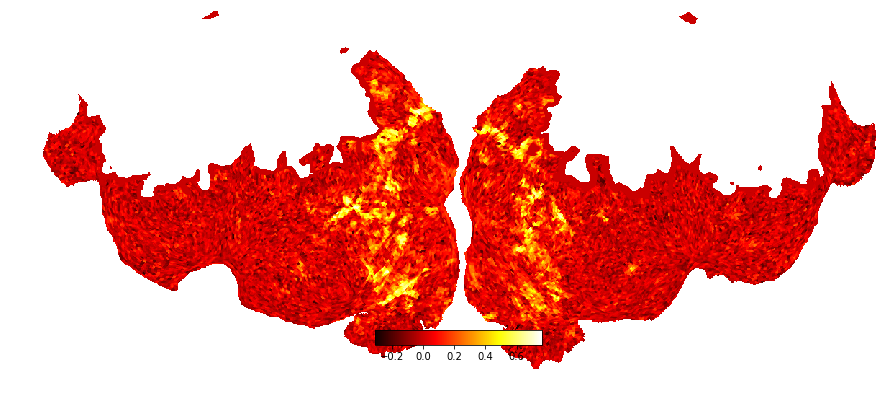

In [22]:
_ = cortex.quickflat.make_figure(cortex.Volume(pred_acc_19_test, subject='s04', xfmname='color_natims', cmap='hot'))

## Encoding Model Comparison

To compare the prediction accuracy performance of two encoding models we can create scatter plots where each point represents the prediction accuracy performance on the two models being compared. Let's have a look.

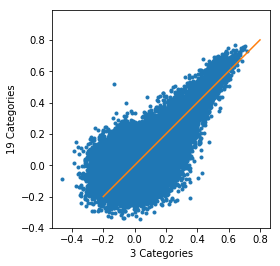

In [26]:
plt.plot(pred_acc_sem3_test, pred_acc_19_test, '.')
plt.plot([-.2,.8], [-.2,.8])
plt.axis('square')
plt.xlabel('3 Categories')
_ = plt.ylabel('19 Categories')

### Gradient Model

We know that neurons in early visual cortex respond to contrast gradients, or edges, in images. Now we'll create an encoding model that captures this property in a crude way to see if we can find an encoding model that fits areas of early visual cortex well.

First we'll load a file which contains all of the images shown to the subjects in the experiment we've been using all lecture.

In [27]:
image_file = h5py.File("/data/cogneuro/fMRI/images/color_natims_images.hdf")

The neurons in the early visual cortex that we're targeting with this model react most strongly to the intensity, or luminance, of an image, and not to it's color. For this reason, we'll convert the images to grayscale to make image processing easier.

In [28]:
images_gray = np.zeros((1386, 96, 96))
images_gray[:1260] = np.rollaxis(image_file['est'][:].mean(axis=2), 2)
images_gray[1260:] = np.rollaxis(image_file['val'][:].mean(axis=2), 2)

Let's plot an example image from this data set to get an idea of what it looks like, and how the gradient model works. This image has been converted to grayscale, it was originally a color image in the experiment.

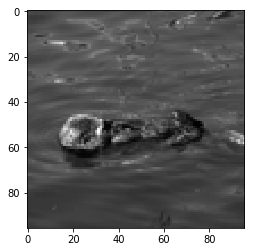

In [29]:
plt.imshow(images_gray[0])
plt.gray()

Now we'll calculate the gradient, or the difference between adjacent voxels, which gives us a measure of how much contrast or change there is in the image. We'll do it in both the x and y axes of the image and average the two.

In [30]:
diff_x = np.diff(images_gray, axis=1)
diff_y = np.diff(images_gray, axis=2)
diff = np.sqrt(diff_x[..., :-1] ** 2 + diff_y[:, :-1] ** 2)

Now let's plot the gradient image to see what information it contains.

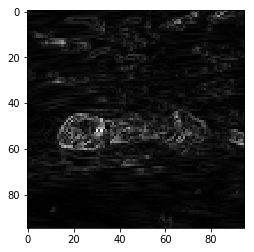

In [31]:
plt.imshow(diff[0])

We can defintely see it roughly finds the "edges" of the image where there is a large change in the pixel intensity. Now let's smooth those differences out before we downsample the image, which is a way of "averaging" the information in multiple pixels. We'll create an image that is 1/100 the number of pixels by downsampling by 10 in the x and y axes.

In [32]:
smoothed = gaussian_filter(diff, sigma=(0, 2, 2))[:, ::10, ::10]

Now let's look at the smoothed and downsampled image.

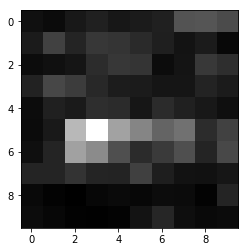

In [33]:
plt.imshow(smoothed[0])

It doesn't really look like much! But you can see roughly where the seal was.

Now we'll use this image as an encoding model!

In [ ]:
model_gradient = LinearRegression()
model_gradient.fit(smoothed[:1260].reshape(1260, -1), data_train)

Calculate the prediction accuracy of this gradient encoding model

In [ ]:
pred_gradient = model_gradient.predict(smoothed[1260:].reshape(-1,100))
pred_acc_gradient = correlate(data_test, pred_gradient)
pred_acc_gradient[pred_acc_gradient>.9] = np.nan

Now plot the predication accuracy performance of this model onto a flatmap. Where do you expect to see this model perform well?

In [ ]:
volume_pred_acc_gradient = cortex.Volume(pred_acc_gradient, subject='s04', xfmname='color_natims', cmap='hot')
_ = cortex.quickflat.make_figure(volume_pred_acc_gradient)

Now compare the Gradient and 19 category encoding model.

In [ ]:
plt.plot(pred_acc_test, pred_acc_19_test, '.')
plt.axis('square')
plt.plot([-.2,.6], [-.2,.6])
plt.xlabel('Energy')
_ = plt.ylabel('19 Categories')

#### Breakout Session

1\. Can you identify which voxels in the scatter plot you think exist in early visual cortex and which exist in later, semantic, areas of visual cortex?

# Decoding (Time Permitting)

Up until now we have been asking the question "What can our knowledge about the stimulus predict about the brain data?". For this, we trained a model on stimulus properties of each TR and had it predict the brain activity on new data.

What if we ask "What can our knowledge of brain activation predict about the stimulus it was being shown?". Asking the question this way is also asking "How much information about the stimulus is in the measured brain data and can we obtain it somehow?". Tackling this question is often called **decoding**. It generally involves predicting an outside measure (such as the stimulus presented or the task performed or the brain state we know the subject is in [e.g. sleeping]) from the brain measurements. So in a modeling context, the brain measurements become the *independent* variable, and the property we are trying to predict becomes the *dependent* variable.

**SO**: Let's see if we can use `LinearRegression` to predict the other way round!

**Questions:**
1. How do we predict each category and maybe dependencies between categories?
2. How do we predict a category if `LinearRegression` predicts numbers?

**Answers:**
1. Here we will predict each category separately
2. Since we are predicting presence/absence of a category, we can predict the value of the z-scored design matrix and then threshold.

**Note:** Here we will be doing a very simple analysis that is typically not conducted this way: Thresholding the outcome of a linear regression is usually not the way categorical variables are predicted. One would more commonly use logistic regression (see `sklearn.linear_model.LogisticRegression`), SVMs (see `sklearn.svm.SVC`), or random forests (see `sklearn.ensemble.RandomForestClassifier`).

## Voxel Selection

Not all the voxels in the brain are going to contain information about what we are trying to predict. However, as we saw last lecture and this lecture, adding more random data to a model makes it more likely to overfit. In order to avoid the precision loss on the test set incurred by overfitting, we will pre-select voxels of which we think they might be useful in this prediction task.

The type of voxel we are aiming for here are voxels that change their mean activity according to whether a concept is present or absent. Note that this is not the only way for a voxel to contain information about the stimulus (it could encode information in the difference of activity between two voxels, for example), but it is a very important type of voxel to search for and will suffice for our purposes.

**How do we find these voxels?**
Changing the mean activity according to whether a stimulus is present or not should ring a bell - this is roughly what encoding model performance can tell us about the voxel. So how about we just select the best performing voxels from an encoding model?

**Strict data separation**
We cannot use the performance of the model on the test set to select the voxels - that is cheating and called *data snooping*. So we will split our train set into a sub-train-set and a sub-test-set called `train_train` and `train_test`. We will use `4/5` of the data for model fitting and `1/5` for the evaluation.

Let's get the indices for this data split:

In [ ]:
train_train_indices = slice(0, 4 * 1260 // 5)  # This is for slicing in order to save memory
train_test_indices = slice(4 * 1260 // 5, 1260) # Could also use np.arange!!

Now the design matrices and data corresponding to these splits:

In [ ]:
designmat_sem3_train_train = designmat_sem3_train[train_train_indices]
designmat_sem3_train_test = designmat_sem3_train[train_test_indices]

data_train_train = data_train[train_train_indices]
data_train_test = data_train[train_test_indices]

In [ ]:
lr = LinearRegression()
lr.fit(designmat_sem3_train_train, data_train_train)

train_test_pred = lr.predict(designmat_sem3_train_test)
train_test_correlations = correlate(train_test_pred, data_train_test)
train_test_correlations.shape

Let's take a look at these in descending order:

In [ ]:
plt.figure(figsize=(20, 2))
plt.plot(sorted(train_test_correlations)[::-1])

If we thresholded at `0.10`, how many voxels would we get?

In [ ]:
(train_test_correlations > 0.10).sum()

That seems like a good number to start with. Let's select those voxels

In [ ]:
cortex.quickshow(cortex.Volume(train_test_correlations > 0.10, 's04', 'color_natims', vmin=0, cmap='hot'))
pass

In [ ]:
selected_voxels = train_test_correlations > 0.10

## Inverting the Regression Model

In [ ]:
lr_decoding = LinearRegression()

We can now mask out only the voxels we care about:

In [ ]:
decoding_X_train_train = data_train_train[:, selected_voxels]
decoding_X_train_test = data_train_test[:, selected_voxels]

decoding_X_test = data_test[:, selected_voxels]

Let's fit category 1:

In [ ]:
lr_decoding.fit(decoding_X_train_train, designmat_sem3_train_train[:, 1])
predicted_categories_continuous = lr_decoding.predict(decoding_X_train_test)

Remember, linear regression gives us continuous predictions, which we will need to threshold:

In [ ]:
plt.hist(predicted_categories_continuous)
pass

In [ ]:
predicted_categories = predicted_categories_continuous > 0

Let's compute the accuracy by comparing when our predicted category is positive and when the design matrix is positive:

In [ ]:
accuracy = np.equal(predicted_categories, (designmat_sem3_train_test[:, 1] > 0)).mean()
accuracy

### Evaluation - is this good or bad?

When evaluating predictive accuracy scores, one always needs to compare to what an uninformed predictor could do:

1. predict completely randomly
2. Predict the most frequent category

Let's check 2.: How often is `designmat_sem3_train_test[:, 1] > 0` anyway?

In [ ]:
(designmat_sem3_train_test[:, 1] > 0).mean()

Roughly half of the time. Our predictor is better than that! So we have inferred information from brain data about this category!

### Breakout session
1. Try the other two categories
2. Try predicting on the actual test set instead of the `train_test` set.
2. Try other voxel selection thresholds. If you are really curious, plot a diagram of accuracy versus selection threshold! Then you can select the best predictor for `train_test` and try it on the actual test set.
3. Evaluate the performance of `sklearn.linear_model.LogisticRegression` on the same task